In [17]:
# Loading

import pandas as pd
df_combined = pd.read_parquet('parquets/house2/df_combined1') # Choose Paquet name

<h3><center><b>RNN / LSTM</b></center></h3>
<hr>

In [18]:
# trimming for full days, need for windowing
import pandas as pd

def trim_data_to_full_days(data):
    if not isinstance(data.index, pd.DatetimeIndex):
        if 'timestamp' in data.columns:
            data['timestamp'] = pd.to_datetime(data['timestamp'])
            data.set_index('timestamp', inplace=True)
        else:
            raise ValueError("Dataframe must have a 'timestamp' column or DatetimeIndex.")

    data = data.sort_index()
    first_full_day = data.index.ceil('D')[0]
    last_full_day = data.index.floor('D')[-1]

    trimmed_data = data[first_full_day:last_full_day]
    return trimmed_data

df_combined = trim_data_to_full_days(df_combined)

In [19]:
for col in df_combined.columns:
    df_combined[col] = pd.to_numeric(df_combined[col], errors='coerce')

In [20]:
X = df_combined[['what_hour', 'what_day', 'is_weekend', 'aggregate', 'agg_clustered']]

Y_columns = df_combined.columns.difference(X.columns)
Y = df_combined[Y_columns]

In [21]:
# one-hot encoding
# Choose devices for training

# columns_to_encode = [ 'hairdryer', '24_inch_lcd_bedroom', 'kettle', 'oven', 'dishwasher', 'washer_dryer'] # house5

columns_to_encode = ['kettle', 'rice_cooker', 'washing_machine', 'dish_washer', 'microwave', 'toaster'] # house2


Y= pd.get_dummies(Y, columns=columns_to_encode)
Y = Y.astype(int)

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled= scaler.fit_transform(X) # normalizing input

In [23]:
import numpy as np

def sliding_window(data, size, step):
    num_windows = 1 + (len(data) - size) // step
    windows = [data[i * step:i * step + size] for i in range(num_windows)]
    return np.array(windows)


window_size = 60
step_size = 30

X_windowed = sliding_window(X_scaled, window_size, step_size)
Y_windowed = sliding_window(Y, window_size, step_size)

print(X_windowed.shape)
print(Y_windowed.shape)

(6575, 60, 5)
(6575, 60, 21)


In [24]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

X_train_val, X_test = train_test_split(X_windowed, test_size=0.15, random_state=42)
X_train, X_val = train_test_split(X_train_val, test_size=0.15/0.85, random_state=42)

Y_train_val, Y_test = train_test_split(Y_windowed, test_size=0.15, random_state=42)
Y_train, Y_val = train_test_split(Y_train_val, test_size=0.15/0.85, random_state=42)

In [25]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_val shape: {Y_val.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (4601, 60, 5)
X_val shape: (987, 60, 5)
X_test shape: (987, 60, 5)
Y_train shape: (4601, 60, 21)
Y_val shape: (987, 60, 21)
Y_test shape: (987, 60, 21)


In [26]:
# RNN / LSTM for one hot encoded data

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

input_shape = (window_size, 5)

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=input_shape),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    Dense(Y_train.shape[-1], activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

model.fit(X_train, Y_train, epochs=30, validation_data=(X_val, Y_val), batch_size=32, callbacks=[early_stopping, model_checkpoint])

results = model.evaluate(X_test, Y_test)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 128)           68608     
                                                                 
 dropout_1 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 60, 128)           131584    
                                                                 
 dense_1 (Dense)             (None, 60, 21)            2709      
                                                                 
Total params: 202901 (792.58 KB)
Trainable params: 202901 (792.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
144/144 [==============================] - 20s 104ms/step - loss: 0.1085 - accuracy: 0.2937 - val_loss: 0.0414 - val_accuracy: 0.0000e+

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/144 [==============================] - 13s 88ms/step - loss: 0.0320 - accuracy: 7.2448e-06 - val_loss: 0.0257 - val_accuracy: 0.0000e+00
Epoch 3/30
144/144 [==============================] - 14s 94ms/step - loss: 0.0221 - accuracy: 3.6224e-06 - val_loss: 0.0193 - val_accuracy: 0.0000e+00
Epoch 4/30
144/144 [==============================] - 16s 112ms/step - loss: 0.0166 - accuracy: 0.0024 - val_loss: 0.0147 - val_accuracy: 0.0105
Epoch 5/30
144/144 [==============================] - 17s 116ms/step - loss: 0.0129 - accuracy: 0.0162 - val_loss: 0.0122 - val_accuracy: 0.0207
Epoch 6/30
144/144 [==============================] - 16s 113ms/step - loss: 0.0108 - accuracy: 0.0254 - val_loss: 0.0103 - val_accuracy: 0.0362
Epoch 7/30
144/144 [==============================] - 18s 122ms/step - loss: 0.0096 - accuracy: 0.0382 - val_loss: 0.0090 - val_accuracy: 0.0463
Epoch 8/30
144/144 [==============================] - 16s 112ms/step - loss: 0.0081 - accuracy: 0.0761 - val_loss: 0.0079 - val

In [27]:
predictions = model.predict(X_test)

# threshold of 0.5 to convert probabilities to binary outputs
y_pred = (predictions > 0.5).astype(int)

31/31 [==============================] - 4s 48ms/step


In [28]:
# Convert predictions to a DataFrame
y_pred_df = pd.DataFrame(y_pred.reshape(y_pred.shape[0] * y_pred.shape[1], y_pred.shape[2]), columns=Y.columns)
Y_test_df = pd.DataFrame(Y_test.reshape(Y_test.shape[0] * Y_test.shape[1], Y_test.shape[2]), columns=Y.columns)

def reverse_one_hot(df):
    result = pd.DataFrame()
    for col in df.columns:
        if '_0' in col:
            base_col = col.rsplit('_', 1)[0]
            one_hot_df = df.filter(like=base_col)
            result[base_col] = one_hot_df.idxmax(axis=1).apply(lambda x: int(x.rsplit('_', 1)[1]))
    return result

# Reverse one-hot encoding
y_pred = reverse_one_hot(y_pred_df)
Y_test = reverse_one_hot(Y_test_df)

Y_test.columns=columns_to_encode
y_pred.columns=columns_to_encode

In [29]:
Y_test_np = Y_test.to_numpy().astype(int)
y_pred_np = y_pred.to_numpy().astype(int)

def exact_match_accuracy(true, pred):
    true = np.array(true)
    pred = np.array(pred)
    exact_matches = np.all(true == pred, axis=1)
    accuracy = np.mean(exact_matches)
    return accuracy

# accuracy
exact_accuracy = exact_match_accuracy(Y_test_np, y_pred_np)
print(f"Exact Match Accuracy: {exact_accuracy:.2%}")

mismatches = Y_test_np != y_pred_np
hamming_losses = mismatches.mean(axis=0)
hamming_accuracies = 1 - hamming_losses

# Hamming accuracy for each label
for i, accuracy in enumerate(hamming_accuracies):
    print(f"Hamming Accuracy for Label {i+1} ({Y_test.columns[i]}): {accuracy:.2%}")

# overall Hamming accuracy
overall_hamming_accuracy = 1 - np.mean(hamming_losses)
print(f"Overall Hamming Accuracy: {overall_hamming_accuracy:.2%}")

Exact Match Accuracy: 99.48%
Hamming Accuracy for Label 1 (kettle): 99.97%
Hamming Accuracy for Label 2 (rice_cooker): 99.96%
Hamming Accuracy for Label 3 (washing_machine): 99.80%
Hamming Accuracy for Label 4 (dish_washer): 99.89%
Hamming Accuracy for Label 5 (microwave): 99.80%
Hamming Accuracy for Label 6 (toaster): 99.97%
Overall Hamming Accuracy: 99.90%


In [30]:
from sklearn.metrics import classification_report

print("Classification Report for each target:")
for column in Y_test.columns:
    print(f"\nClassification Report for {column}:")
    print(classification_report(Y_test[column], y_pred[column], zero_division=0))


Classification Report for each target:

Classification Report for kettle:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58809
           1       0.00      0.00      0.00         7
           2       0.98      0.99      0.99       404

    accuracy                           1.00     59220
   macro avg       0.66      0.66      0.66     59220
weighted avg       1.00      1.00      1.00     59220


Classification Report for rice_cooker:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58853
           1       0.96      0.94      0.95       194
           2       0.99      0.98      0.99       173

    accuracy                           1.00     59220
   macro avg       0.98      0.97      0.98     59220
weighted avg       1.00      1.00      1.00     59220


Classification Report for washing_machine:
              precision    recall  f1-score   support

           0       1.00  

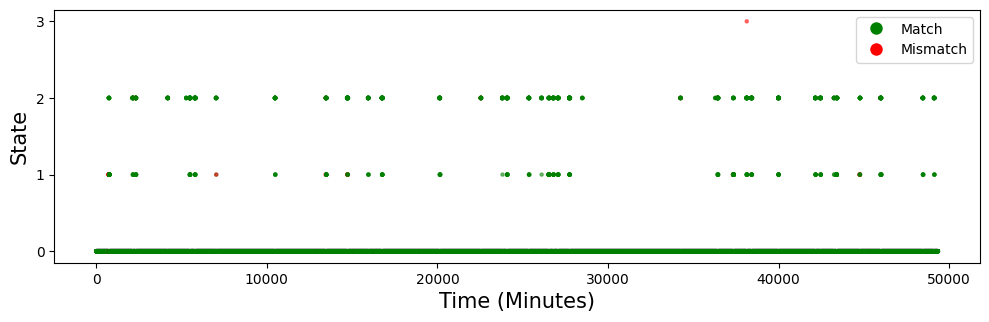

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

#  Choose device number for visualization
device = 3
n_samples =  49345

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
y_pred = pd.DataFrame(y_pred)

colors = np.array(['green' if int(a) == int(b) else 'red' for a, b in zip(y_pred.iloc[:n_samples, device], Y_test.iloc[:n_samples, device])])

x_indices = Y_test.index[:n_samples]

scatter = plt.scatter(x_indices, Y_test.iloc[:n_samples, device].astype(int),
                      c=colors, alpha=0.5, s=5)

plt.yticks(np.arange(min(Y_test.iloc[:n_samples, device].astype(int)), max(Y_test.iloc[:n_samples, device].astype(int)) + 1))

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Match',
                          markerfacecolor='green', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Mismatch',
                          markerfacecolor='red', markersize=10)]
plt.legend(handles=legend_elements, loc='upper right')

plt.ylabel('State', fontsize=15)
plt.xlabel('Time (Minutes)', fontsize=15)

plt.tight_layout()
plt.show()